In [1]:
#Importing all the necessary Libraries
import numpy as np 
import pandas as pd 
import pywt
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 

Using TensorFlow backend.


In [2]:
#Attach the path to your dataset.
df=pd.read_csv('D:/Ear-Stimuli/eardataset.csv')
df=pd.read_csv('eardataset.csv', encoding = "ISO-8859-1")

###### Data Preprocessing and Visualisation

In [3]:
print(df.info())
print("----Check if Data has any null values----")
print(df.isnull().sum())
if(df.isnull().values.any()==False):
    print("\nNo null Values in the dataset")
else:
    print("\ndataset has null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Columns: 666 entries, unnamed to data_659
dtypes: float64(660), int64(4), object(2)
memory usage: 22.0+ MB
None
----Check if Data has any null values----
unnamed     0
subject     0
session     0
ear         0
buffer      0
           ..
data_655    0
data_656    0
data_657    0
data_658    0
data_659    0
Length: 666, dtype: int64

No null Values in the dataset


In [4]:
df_again = pd.read_csv('D:/Ear-Stimuli/eardataset.csv')
df_again.head(3)

,unnamed,subject,session,ear,buffer,block,data_0,data_1,data_2,data_3,...,data_650,data_651,data_652,data_653,data_654,data_655,data_656,data_657,data_658,data_659
0,40,0,0,left,A,40,0.000062,0.000063,0.000064,0.000067,...,-0.000046,-0.000048,-0.000049,-0.000051,-0.000052,-0.000052,-0.000053,-0.000053,-0.000052,-0.000051
1,41,0,0,left,A,41,0.000063,0.000064,0.000065,0.000067,...,-0.000039,-0.000040,-0.000042,-0.000043,-0.000044,-0.000044,-0.000044,-0.000044,-0.000044,-0.000042
2,42,0,0,left,A,42,0.000065,0.000066,0.000067,0.000069,...,-0.000042,-0.000043,-0.000045,-0.000046,-0.000047,-0.000047,-0.000047,-0.000047,-0.000047,-0.000045


In [5]:
df_again=df_again.drop(["unnamed", "session","ear","buffer","block"],axis=1)

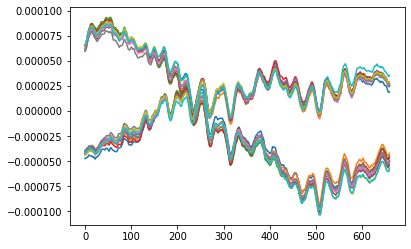

In [6]:
#View the signals in the dataset
for i in range(0,20):
    disp = df_again.iloc[i,1:661].values
    plt.plot(disp)
#10 consecutive signals are similar in a dataset while the next consecutive 10 are not.

In [7]:
#creating a dataFrame for the dataset
def subject0(subjectno, sessionno, earname, bufferid):
    dfu0=df.groupby(['subject', 'session', 'ear', 'buffer']).get_group((subjectno, sessionno, earname, bufferid)).iloc[-10:]
    return dfu0

x=subject0(34,0,'left','B')
x['subject'].iloc[0]
print(x.shape)
print(x)

(10, 666)
      unnamed  subject  session   ear buffer  block    data_0    data_1  \
2730    30662       34        0  left      B    272  0.000014  0.000013   
2731    30663       34        0  left      B    273  0.000014  0.000013   
2732    30664       34        0  left      B    274  0.000014  0.000013   
2733    30665       34        0  left      B    275  0.000015  0.000014   
2734    30666       34        0  left      B    276  0.000014  0.000013   
2735    30667       34        0  left      B    277  0.000014  0.000014   
2736    30668       34        0  left      B    278  0.000014  0.000014   
2737    30669       34        0  left      B    279  0.000013  0.000013   
2738    30670       34        0  left      B    280  0.000014  0.000014   
2739    30671       34        0  left      B    281  0.000015  0.000014   

        data_2    data_3  ...  data_650  data_651  data_652  data_653  \
2730  0.000013  0.000013  ...  0.000013  0.000012  0.000011  0.000011   
2731  0.000013  0.

In [8]:
#Creating Input and Labels DataFrame

allInputTEOAEsignalsAllSubjects = pd.DataFrame([])
allOutputLabelsAllSubjects = pd.DataFrame([])
for a in range(54):
    print(a)
    df1 = pd.DataFrame([])
    b=[0,1]              # sessions 0 and 1
    c=['left','right']   # ears 
    d=['A','B']          # buffers
    
    allFeatures =  pd.DataFrame([])
    allInputFeatures =  pd.DataFrame([])
    outputLabel =  pd.DataFrame([])
    fftValues =  pd.DataFrame([])
    psdValues =  pd.DataFrame([])
    autocorrValues = pd.DataFrame([])
        
    for q,r,s in [(q,r,s) for q in b for r in c for s in d]:
        
        # df1 contains all the 80 TEOAE signals of subject a
        df1 = df1.append(subject0(a,q,r,s))
        allInputFeatures = df1.iloc[:,6:]
    
    allInputTEOAEsignalsAllSubjects = pd.concat([allInputTEOAEsignalsAllSubjects.reset_index(drop=True),
                                                 allInputFeatures.reset_index(drop=True)], axis=0)
    # the following gets you the class label <= subject no.[0,1,2,...,53]
    outputLabel = df1.iloc[:,1] 
    print("OutputLabel:",outputLabel)
    #allOutputLabelsAllSubjects = allOutputLabelsAllSubjects.append(outputLabel)
    #append didn't work for output so using pd.cat instead
    allOutputLabelsAllSubjects = pd.concat([allOutputLabelsAllSubjects.reset_index(drop=True),
                                            outputLabel.reset_index(drop=True)], axis=0)
    print(allInputTEOAEsignalsAllSubjects.shape)
    print(allOutputLabelsAllSubjects.shape)


0
OutputLabel: 0     0
1     0
2     0
3     0
4     0
     ..
75    0
76    0
77    0
78    0
79    0
Name: subject, Length: 80, dtype: int64
(80, 660)
(80, 1)
1
OutputLabel: 80     1
81     1
82     1
83     1
84     1
      ..
155    1
156    1
157    1
158    1
159    1
Name: subject, Length: 80, dtype: int64
(160, 660)
(160, 1)
2
OutputLabel: 160    2
161    2
162    2
163    2
164    2
      ..
235    2
236    2
237    2
238    2
239    2
Name: subject, Length: 80, dtype: int64
(240, 660)
(240, 1)
3
OutputLabel: 240    3
241    3
242    3
243    3
244    3
      ..
315    3
316    3
317    3
318    3
319    3
Name: subject, Length: 80, dtype: int64
(320, 660)
(320, 1)
4
OutputLabel: 320    4
321    4
322    4
323    4
324    4
      ..
395    4
396    4
397    4
398    4
399    4
Name: subject, Length: 80, dtype: int64
(400, 660)
(400, 1)
5
OutputLabel: 400    5
401    5
402    5
403    5
404    5
      ..
475    5
476    5
477    5
478    5
479    5
Name: subject, Length: 80, dt

(3520, 660)
(3520, 1)
44
OutputLabel: 3520    44
3521    44
3522    44
3523    44
3524    44
        ..
3595    44
3596    44
3597    44
3598    44
3599    44
Name: subject, Length: 80, dtype: int64
(3600, 660)
(3600, 1)
45
OutputLabel: 3600    45
3601    45
3602    45
3603    45
3604    45
        ..
3675    45
3676    45
3677    45
3678    45
3679    45
Name: subject, Length: 80, dtype: int64
(3680, 660)
(3680, 1)
46
OutputLabel: 3680    46
3681    46
3682    46
3683    46
3684    46
        ..
3755    46
3756    46
3757    46
3758    46
3759    46
Name: subject, Length: 80, dtype: int64
(3760, 660)
(3760, 1)
47
OutputLabel: 3760    47
3761    47
3762    47
3763    47
3764    47
        ..
3835    47
3836    47
3837    47
3838    47
3839    47
Name: subject, Length: 80, dtype: int64
(3840, 660)
(3840, 1)
48
OutputLabel: 3840    48
3841    48
3842    48
3843    48
3844    48
        ..
3915    48
3916    48
3917    48
3918    48
3919    48
Name: subject, Length: 80, dtype: int64
(3920

In [9]:
# save extracted dataframe locally
X=pd.DataFrame([])
y=pd.DataFrame([])
xsave = pd.DataFrame([])
ysave = pd.DataFrame([])
X = allInputTEOAEsignalsAllSubjects
y = allOutputLabelsAllSubjects
xsave = X
ysave = y
#xsave.to_pickle('dataX.pkl')
#ysave.to_pickle('labelY.pkl')

In [ ]:
#Load from pkl files
X = pd.read_pickle('dataX.pkl')
y = pd.read_pickle('labelY.pkl')

In [10]:
#Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [11]:
#Checking the dimensions of train and test array
print(np.asarray(X_train).shape)
print(np.asarray(X_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
print(np.asarray(labels_train).shape)

(3456, 660)
(864, 660)
(3456, 1)
(864, 1)
(3456,)


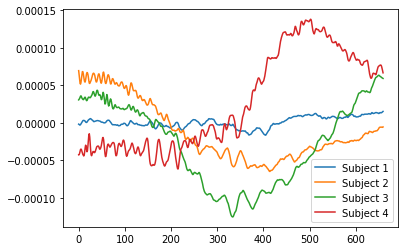

In [12]:
# Check if continuous waves are similar to each other in X_train
for i in range(1,5):
    X_disp = X_train.iloc[i,:].values
    plt.plot(X_disp, label = "Subject "+str(i))
    plt.legend()
#Conclusion : NOPE!

###### Continuous Wavelets Transform on the Data-signal

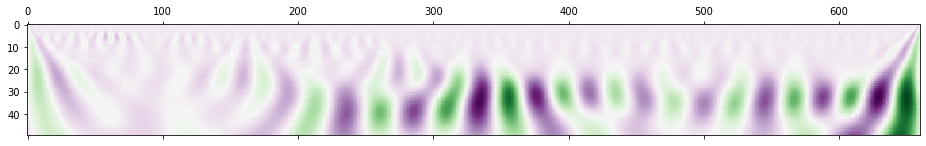

In [13]:
#scales = range(1,661)
scales = range(1,51)
waveletname = 'morl'
train_size = 3456
test_size= 864

#################################################
### plotting CWT of a single TEOAE signal  ######
#################################################
coeff, freq = pywt.cwt(X_train.iloc[3,:], scales, waveletname, 1)
plt.matshow(coeff,  cmap='PRGn', aspect='auto')
plt.show()

In [14]:
scales = range(1,51)
waveletname = 'morl'
train_size = X_train.shape[0]
test_size= X_test.shape[0]

#########################################################
### creating a tensor to store CWT matrices of train egs#
#########################################################
train_data_cwt = np.ndarray(shape=(train_size, 50, 660)) 

for ii in range(0,train_size):
    if ii % 50 == 0: #len(X_train) == 0:
        print(ii)
    signal = X_train.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    train_data_cwt[ii, :, :] = coeff_
    #train_data_cwt[:, :, ii] = coeff_

###########################################################
### creating a tensor to store CWT matrices of test egs ###
###########################################################
test_data_cwt = np.ndarray(shape=(test_size, 50, 660))

for ii in range(0,test_size):
    if ii % 50 == 0:
        print(ii)
    signal = X_test.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    test_data_cwt[ii, :, :] = coeff_
    #test_data_cwt[:, :, ii] = coeff_

###########################################################
### convert the labels from float to int of train and test egs
###########################################################
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
labels_test = list(map(lambda x: int(x), np.asarray(y_test)))

###########################################################
### putting all the train and test CWT data             ###
###########################################################
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850


In [15]:
#Convert the labels to array
y_test_np = np.asarray(y_test)
y_train_np = np.asarray(y_train)

In [16]:
print(np.asarray(x_train).shape)
print(np.asarray(x_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
print(len(x_train))
print(len(x_test))

(3456, 50, 660)
(864, 50, 660)
(3456,)
(864,)
3456
864


In [ ]:
# save numpy array
np.save('x_train_CNN', x_train)
np.save('x_test_CNN', x_test)
np.save('y_test_CNN', y_test_np)
np.save('y_train_CNN', y_train_np)

In [ ]:
#load data
x_train = np.load('x_train_CNN.npy')
x_test = np.load('x_test_CNN.npy')
y_train_np = np.load('y_train_CNN.npy')
y_test_np = np.load('y_test_CNN.npy')

###### Feature extraction by CNN

In [17]:
#A simple CNN network is used to extract the features
history = History()
 
img_x = x_train.shape[1] # = no.of samples of each TEOAE signal = 660
img_y = x_train.shape[2] 
img_z = 1

input_shape = (img_x, img_y, img_z)
 
num_classes = 54
# batch_size = 64
# epochs = 100

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)

x_train_cnn = x_train.reshape(3456,50,660,1)#len(x_train),img_x, img_y, img_z)
x_test_cnn = x_test.reshape(864,50,660,1)#len(x_test),img_x, img_y, img_z)
y_train_cnn = keras.utils.to_categorical(y_train_np, num_classes)
y_test_cnn = keras.utils.to_categorical(y_test_np, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(num_classes, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

#model.add(Flatten())

model.summary()

(3456, 50, 660)
(864, 50, 660)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 656, 32)       832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 328, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 324, 64)       51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 162, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
Total params: 52,096
Trainable params: 52,096
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
#obtain the flattened output for training
features_xtrain=model.predict(x_train_cnn) #training
features_xtrain.shape

(3456, 93312)

In [20]:
#Flattened output for Testing
features_xtest=model.predict(x_test_cnn) #testing
features_xtest.shape

(864, 93312)

###### Principle Component Analysis for Feature Reduction

In [21]:
# PCA on the flattened array

scaler = StandardScaler()
scaler.fit(features_xtrain)

features_xtrain = scaler.transform(features_xtrain)
features_xtest = scaler.transform(features_xtest)

pca = PCA(.95)  #using 95% of the variance in the model.

pca.fit(features_xtrain)

features_xtrain = pca.transform(features_xtrain)
features_xtest = pca.transform(features_xtest)

In [22]:
print(features_xtrain.shape)
print(features_xtest.shape)

(3456, 264)
(864, 264)


In [23]:
 #SVM classifier

svm=SVC()
svm.fit(features_xtrain,y_train_np)

#training accuracy
acc_svm_train=round(svm.score(features_xtrain,y_train_np)*100,2)
print("Training Accuracy:",acc_svm_train)

#testing accuracy
acc_svm_test=round(svm.score(features_xtest,y_test_np)*100,2)
print("Testing accuracy:",acc_svm_test)

Training Accuracy: 98.9
Testing accuracy: 98.96


In [26]:
# MLP classification
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,150,100), max_iter=50, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=0,tol=0.000001)
mlp_clf.fit(features_xtrain, y_train_np)

pred_test = mlp_clf.predict(features_xtest) #testing accuracy
print('Accuracy: ')
print(accuracy_score(y_test_np, pred_test)*100)
print('Confusion Matrix :')
print(confusion_matrix(y_test_np, pred_test)) 
print('Report : ')
print(classification_report(y_test_np, pred_test))

Iteration 1, loss = 5.78537612
Iteration 2, loss = 0.92851538
Iteration 3, loss = 0.22313607
Iteration 4, loss = 0.07385487
Iteration 5, loss = 0.03386704
Iteration 6, loss = 0.01921126
Iteration 7, loss = 0.01303790
Iteration 8, loss = 0.00968606
Iteration 9, loss = 0.00723378
Iteration 10, loss = 0.00579456
Iteration 11, loss = 0.00477078
Iteration 12, loss = 0.00404394
Iteration 13, loss = 0.00346023
Iteration 14, loss = 0.00300272
Iteration 15, loss = 0.00260009
Iteration 16, loss = 0.00226853
Iteration 17, loss = 0.00201707
Iteration 18, loss = 0.00181034
Iteration 19, loss = 0.00164107
Iteration 20, loss = 0.00149154
Iteration 21, loss = 0.00136778
Iteration 22, loss = 0.00126076
Iteration 23, loss = 0.00116616
Iteration 24, loss = 0.00108346
Iteration 25, loss = 0.00100685
Iteration 26, loss = 0.00094215
Iteration 27, loss = 0.00088540
Iteration 28, loss = 0.00083355
Iteration 29, loss = 0.00078662
Iteration 30, loss = 0.00074614
Iteration 31, loss = 0.00070785
Iteration 32, los

C:\Users\harsh\.conda\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


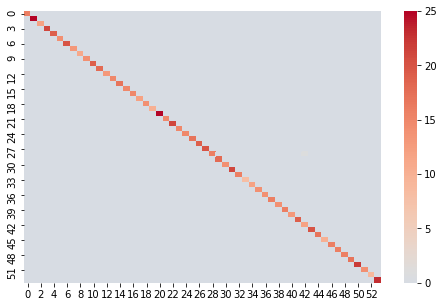

In [30]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)
plt.figure(figsize=(8,5))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [32]:
#Random Forest Classifier

# Create the model with 100 trees
model_rf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model_rf.fit(features_xtrain, y_train_np)
pred_test = model_rf.predict(features_xtest) #testing accuracy

print('Accuracy: ')
print(accuracy_score(y_test_np, pred_test)*100)
print('Confusion Matrix :')
print(confusion_matrix(y_test_np, pred_test)) 
print('Report : ')
print(classification_report(y_test_np, pred_test))

Accuracy: 
100.0
Confusion Matrix :
[[16  0  0 ...  0  0  0]
 [ 0 25  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0  9  0]
 [ 0  0  0 ...  0  0 23]]
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.

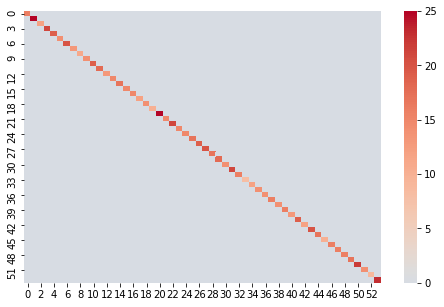

In [33]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(8,5))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [34]:
# K nearest neighbours algorithm 

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(features_xtrain, y_train_np) 
pred_test = knn.predict(features_xtest) #testing accuracy
print('Accuracy: ')
print(accuracy_score(y_test_np, pred_test)*100)
print('Confusion Matrix :')
print(confusion_matrix(y_test_np, pred_test)) 
print('Report : ')
print(classification_report(y_test_np, pred_test))

Accuracy: 
100.0
Confusion Matrix :
[[16  0  0 ...  0  0  0]
 [ 0 25  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0  9  0]
 [ 0  0  0 ...  0  0 23]]
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.

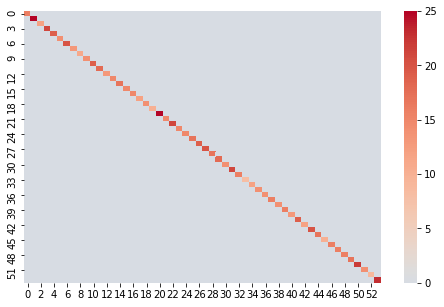

In [35]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(8,5))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [59]:
# XGBoost classifier

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(features_xtrain, y_train_np)
pred_test = model.predict(features_xtest) #testing accuracy
print('Accuracy: ')
print(accuracy_score(y_test_np, pred_test)*100)
print('Confusion Matrix :')
print(confusion_matrix(y_test_np, pred_test)) 
print('Report : ')
print(classification_report(y_test_np, pred_test))

Accuracy: 
99.76851851851852
Confusion Matrix :
[[16  0  0 ...  0  0  0]
 [ 0 25  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0  9  0]
 [ 0  0  0 ...  0  0 23]]
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        19
           5       0.93      1.00      0.97        14
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        13
          13       1.00      

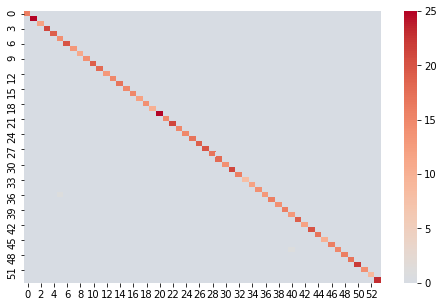

In [60]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(8,5))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()